In [11]:
from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [18]:
def lamda_to_um(diam, Ra, Rm, lamda_size):
    lamda = np.sqrt((Rm/Ra) * (diam/10000.0/4))
    return lamda*10000.0*lamda_size

def l_to_L(l, sec):
    Rm=1.0/sec.g_pas
    lamda = np.sqrt((Rm/sec.Ra) * (sec.diam/10000.0/4))
    return l/(lamda*10000)

def get_model(L=1, diam=1, Cm=1, Rm=10000, Ra=100, e_pas=-70,add_soma=False, soma_diam=10):
    assert L>0
    model=dict()
    model['base'] = h.Section()
    model['base'].diam=diam
    model['base'].L = lamda_to_um(model['base'].diam, Ra, Rm, L)

    if add_soma:
        model['soma'] = h.Section()    
        model['base'].connect(model['soma'], 1)
        model['soma'].L=model['soma'].diam=soma_diam
    
    for sec_name, sec in model.items():
        sec.insert('pas')
        sec.cm=Cm
        sec.Ra=Ra
        sec.g_pas = 1.0/Rm
        sec.e_pas=e_pas        
        sec.nseg = int(sec.L/10)+1
        
    return model
 
def add_syn(seg, g_AMPA, g_NMDA, START_TIME=100, e=0):
    # AMPA part
    netstim = h.NetStim()
    netstim.interval = 1
    netstim.start = START_TIME
    netstim.noise = 0
    netstim.number = 1
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con = h.NetCon(netstim, AMPA)
    AMPA.e = e
    AMPA.tau1 = 0.3
    AMPA.tau2 = 3
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA = h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = e
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def get_neck_l(Ri, neck_diam, R_neck):
    return R_neck/(4*Ri/(np.pi*neck_diam**2)/100)

def add_spine(seg, R_neck=0):  # np.sqrt(2.8/(4*np.pi))
    if R_neck<=0:
        return [seg, seg]
    neck_diam=0.25
    neck_length = get_neck_l(Ri=seg.sec.Ra, neck_diam=neck_diam, R_neck=R_neck)
    head_diam = 0.944
    
    neck = h.Section()
    head = h.Section()

    neck.L = neck_length
    neck.diam = neck_diam
    head.L = head.diam = head_diam
    head.connect(neck(1))
    neck.connect(seg)
    for sec in [neck, head]:
        sec.insert("pas")
        sec.g_pas = seg.g_pas
        sec.e_pas = seg.e_pas
        sec.cm= seg.cm
        sec.Ra=seg.sec.Ra
    return neck, head

def add_synapse(seg, g_AMPA, g_NMDA, START_TIME=100, e=0, R_neck=150): 
        neck, head = add_spine(seg, R_neck=R_neck)
        if not head == seg:
            syn_seg = list(head)[-1]
        else:
            syn_seg = seg
        syn = add_syn(syn_seg, g_AMPA, g_NMDA, START_TIME, e)
        return syn, [neck, head]
    
def transfer_freq(seg1, seg2, freqs = np.exp(np.linspace(0, np.log(1000), 10000))):
    imp = h.Impedance(seg1.x, sec=seg1.sec)
    imp.loc(seg1.x, sec=seg1.sec)
    transfer = []
    for freq in freqs:
        imp.compute(freq, 1)
        transfer.append(imp.transfer(seg2.x, sec=seg2.sec))
    return freqs, np.array(transfer)

def get_dist_to_soma(seg, start=True):
    if start:
        start=False
        total_dist = 0
        for seg_i in seg.sec:
            if seg_i.x<=seg.x:
                total_dist+=l_to_L(seg.sec.L/seg.sec.nseg, seg.sec)
    else:
        total_dist=l_to_L(seg.sec.L, seg.sec)
    if seg.sec.parentseg().sec.name() == 'soma':
        return total_dist
    return total_dist+get_dist_to_soma(seg.sec.parentseg(), start=start)

def get_dist_to_start(seg, start=True):
    total_dist=0
    for seg_i in seg.sec:
        if seg_i.x<=seg.x:
            total_dist+=l_to_L(seg.sec.L/seg.sec.nseg, seg.sec)
    return total_dist
    


In [19]:
def run_step(model, syn, seg, g_AMPA=0.0004, g_NMDA=0.0012):
    
#     [AMPA, AMPA_con], [NMDA, NMDA_con], netstim
    syn[0][0].loc(seg)
    syn[1][0].loc(seg)
    syn[0][1].weight[0] = g_AMPA
    syn[1][1].weight[0] = g_NMDA
    
    T = h.Vector()
    V = h.Vector()
    T.record(h._ref_t)
    if 'soma' in model:
        V.record(model['soma'](0.5)._ref_v)
        h.v_init=model['soma'].e_pas
    else:
        V.record(list(model['base'])[0]._ref_v)
        h.v_init=model['base'].e_pas

        
    h.tstop = 200
    h.run()
    T = np.array(T)
    V = np.array(V)
    return T, V


def run(L=10, diam=1, g_AMPA=0.0004, g_NMDA=0.0012, g_mul=np.arange(0, 5, 0.2), poses = np.arange(0, 1, 0.01)):
    
    model = get_model(L=L, diam=diam, Cm=1, Rm=10000, Ra=100, e_pas=-70,add_soma=False, soma_diam=10)
    seg_list = list(model['base'])
    seg = list(model['base'])[0]
    
    syn = add_syn(seg, g_AMPA, g_NMDA, START_TIME=100, e=0)
    res = np.zeros((len(poses), len(g_mul)))
    for i, mul in tqdm(enumerate(g_mul), desc='mul', total=len(g_mul)):
        for j, pos in enumerate(poses):
            seg = seg_list[int(len(seg_list)*pos)]
            T, V = run_step(model, syn, seg, g_AMPA=g_AMPA*mul, g_NMDA=g_NMDA*mul)
            res[j,i] = V.max()-V.min()
    return res
            

In [30]:

g_mul=np.arange(0, 20, 0.5)
poses = np.arange(0, 1, 0.005)
res=run(L=5, 
        diam=1, 
        g_AMPA=0.0004, 
        g_NMDA=0.0012, 
        g_mul=g_mul, 
        poses = poses)

mul: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:20:03<00:00, 120.08s/it]


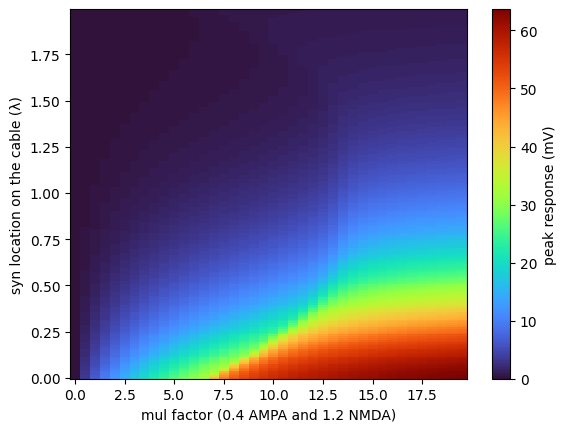

In [31]:
plt.pcolormesh(g_mul, poses*2, res, cmap='turbo')
cax=plt.colorbar()
cax.ax.set_ylabel('peak response (mV)')
plt.xlabel('mul factor (0.4 AMPA and 1.2 NMDA)')
plt.ylabel('syn location on the cable (\u03BB)')
plt.savefig('simple_model_respose_in_cable_of_5_lamda')
plt.savefig('simple_model_respose_in_cable_of_5_lamda.pdf')

In [25]:
cax.ax

<Axes: label='<colorbar>'>